### Simulate the flight reservation process (MZ685 Case Vocram)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import random

In [2]:
# Constants
FLIGHTS = 1000    # The number of flights for simulation (can be changed)
CALLS = 10        # The number of calls for each flight
SEATS = 3         # The number of available seats for each flight
WTP_PUBLIC = 100  # The WTP upper bound of public employee
WTP_PRIVATE = 150 # The WTP upper bound of private individual
P = 0.5           # P:   The probability of a call being public employee 
                  # 1-P: The probability of a call being private individual

### Replicate the Status Quo

Assumptions:

* Single price: $65
* The WTP of public employee follows a discrete uniform distribution [1, 100]
* The WTP of private individual follows a discrete uniform distribution [1, 150]
* A strict first-call first-serve system: whoever called and made a reservation for a specific departure would be given a seat, provided one was available.

Simulation results are expected to be in line with the fact:

Historically, 40% of the clients were scientists/researchers/public employees and 60% were private individuals.

In [3]:
def one_flight(flight_no, price, reservations):
    """Simulate the reservation process for one flight.
    
    Parameters
    ----------
    flight_no: flight sequence number for bookkeeping
    """
    seats_left = SEATS
    
    for i in range(CALLS):
        whocall = [0, 1][random()>P]
        if whocall == 0: # 0-public employee
            wtp = np.random.randint(1, WTP_PUBLIC+1)
            if wtp >= price:
                seats_left -= 1
                reservations.append((flight_no, whocall, wtp))
                if seats_left == 0:
                    break
        elif whocall == 1: # 1-private individual
            wtp = np.random.randint(1, WTP_PRIVATE+1)
            if wtp >= price:
                seats_left -= 1
                reservations.append((flight_no, whocall, wtp))
                if seats_left == 0:
                    break     

In [4]:
def revenue(price, more_info=False):
    """Simulate FLIGHT times and return the average revenue per flight.
    """
    reservations = []
    
    for i in range(1, FLIGHTS+1):
        one_flight(i, price, reservations)
    
    avg_revenue = price * len(reservations) / FLIGHTS
    
    if more_info == True:
        print('The # of availabe seats in {} flights is {}. The # of seats sold is {}.' \
              .format(FLIGHTS, FLIGHTS*SEATS, len(reservations)))
        pcnt = ((pd.DataFrame(reservations, columns=['flight_no', 'whocall', 'wtp'])). \
                groupby('whocall').size()) / len(reservations) * 100
        title = 'Price: \$' + str(price) + ',  Average revenue per flight: \$' + str(round(avg_revenue)) + \
                '\n' + ' %' + str(round(len(reservations) / (FLIGHTS*SEATS) * 100)) + ' seats were sold'
        ax = pcnt.plot(kind='bar', title=title, figsize=(8,5))
        ax.set_xlabel("0-public employee   1-private individual")
        ax.set_ylabel("Percent (%)")
        
    return avg_revenue

The # of availabe seats in 1000 flights is 3000. The # of seats sold is 2895.


188.175

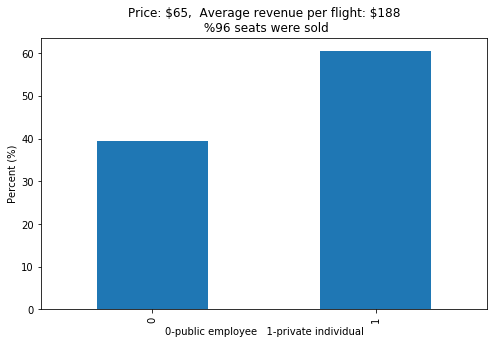

In [5]:
revenue(65, True)

### Get the Optimal Single Price

In [6]:
# Step 1: Get a rough range of the optimal single price

optimal_price, max_revenue = 1, 1

for p in range(60, 150):
    r = revenue(p)
    if max_revenue < r:
        optimal_price, max_revenue = p, r
        
print(optimal_price, max_revenue)

80 210.88


In [7]:
# Step 2: Run simulation many times within a smaller price range

optima = []

for i in range(100):
    optimal_price, max_revenue = 1, 1
    
    for p in range(75, 90):
        r = revenue(p)
        if max_revenue < r:
            optimal_price, max_revenue = p, r
            
    optima.append((optimal_price, max_revenue))    

In [8]:
# Step 3: Average the results from Step 2 to get the optimal single price

(pd.DataFrame(optima, columns=['price', 'revenue'])).mean()

price       81.54000
revenue    211.05657
dtype: float64

The # of availabe seats in 1000 flights is 3000. The # of seats sold is 2545.


208.69

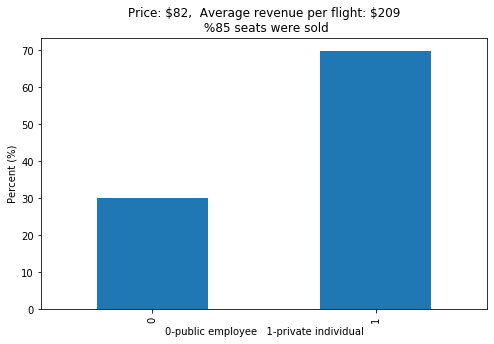

In [9]:
revenue(82, True)

### Two-tier Pricing

Assumptions:
* Stu will ask a customer calling in to know what type the person belongs to. For public employee, he will quote the high price; for private individual, he will quote the low price.
* Stu doesn't set a booking limit for public employee.


In [10]:
def one_flight_two_tier(flight_no, high_price, low_price, reservations, booking_limit=SEATS):
    """ Simulate the reservation process for one flight with two-tier pricing system
    
    Parameters
    ----------
    flight_no: flight sequence number for bookkeeping
    high_price: price for private individual
    low_price:  price for public employee
    booking_limit: the max number of seats allocated to public employee per flight
    """

    seats_left = SEATS
    seats_for_public = booking_limit
    
    for i in range(CALLS):
        whocall = [0, 1][random()>P]
        if whocall == 0: # 0-public employee
            wtp = np.random.randint(1, WTP_PUBLIC+1)
            if seats_for_public == 0:
                continue
            if wtp >= low_price:
                seats_left -= 1
                seats_for_public -= 1
                reservations.append((flight_no, whocall, wtp))
                if seats_left == 0:
                    break
        elif whocall == 1: # 1-private individual
            wtp = np.random.randint(1, WTP_PRIVATE+1)
            if wtp >= high_price:
                seats_left -= 1
                reservations.append((flight_no, whocall, wtp))
                if seats_left == 0:
                    break

In [11]:
def revenue_two_tier(high_price, low_price, booking_limit=SEATS, more_info=False):
    """Return the average revenue per flight
    """
    reservations = []
    
    for i in range(1, FLIGHTS+1):
        one_flight_two_tier(i, high_price, low_price, reservations, booking_limit)
    
    df = pd.DataFrame(reservations, columns=['flight_no', 'whocall', 'wtp'])
    avg_revenue = (high_price * len(df[df.whocall==1]) + low_price * len(df[df.whocall==0])) / FLIGHTS
    
    if more_info == True:
        print('The # of availabe seats in {} flights is {}. The # of seats sold is {}.' \
              .format(FLIGHTS, FLIGHTS*SEATS, len(reservations)))
        pcnt = df.groupby('whocall').size() / len(reservations) * 100
        title = 'High Price: \$' + str(high_price) + ', Low Price: \$' + str(low_price) + \
                '\nAverage revenue per flight: \$' + str(round(avg_revenue)) + \
                '\n' + ' %' + str(round(len(reservations) / (FLIGHTS*SEATS) * 100)) + ' seats were sold'
        ax = pcnt.plot(kind='bar', title=title, figsize=(8,5))
        ax.set_xlabel("0-public employee   1-private individual")
        ax.set_ylabel("Percent (%)")
        
    return avg_revenue

### Get the Optimal Two-tier System

In [12]:
# Step 1: Get rough ranges of the optimal two prices

optimal_high_price, optimal_low_price, max_revenue = 1, 1, 1

for high in range(70, 150):
    for low in range(50, 100):
        r = revenue_two_tier(high, low)
        if max_revenue < r:
            max_revenue = r
            optimal_high_price, optimal_low_price = high, low
            
print(optimal_high_price, optimal_low_price, max_revenue)

103 73 224.178


In [13]:
# Step 2: Run simulation many times within smaller price ranges

N = 100
optima = []

for i in range(N):
    optimal_high_price, optimal_low_price, max_revenue = 1, 1, 1
    
    for high in range(90, 110):
        for low in range(65, 80):
            r = revenue_two_tier(high, low)
            if max_revenue < r:
                max_revenue = r
                optimal_high_price, optimal_low_price = high, low
                
    optima.append((optimal_high_price, optimal_low_price, max_revenue))   


In [14]:
# Step 3: Average the results from Step 2 to get the optimal two prices

(pd.DataFrame(optima, columns=['high_price', 'low_price', 'revenue'])).mean()

high_price     97.9200
low_price      72.6400
revenue       223.4259
dtype: float64

The # of availabe seats in 1000 flights is 3000. The # of seats sold is 2523.


218.754

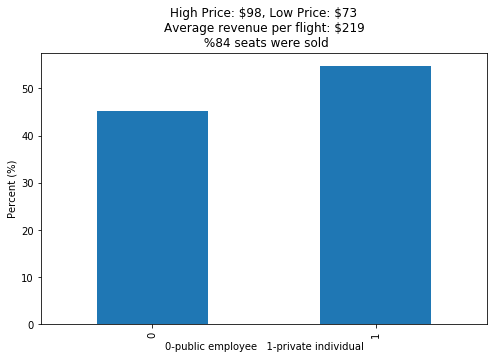

In [20]:
revenue_two_tier(98, 73, more_info=True)